In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, make_scorer, f1_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.cm as cm
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
#%matplotlib notebook
#plt.style.use('ggplot')

In [3]:
pd.set_option('display.max_columns', None)

#reads in each csv separately
pitches = pd.read_csv('../data/pitches.csv', low_memory=False)

In [4]:
#finds all nans and uses np.where to grab axis [0] grabs first of tuple
rows_with_nans = np.where(pitches.isna().any(axis=1) == True)[0]

#new df with dropped nans, inplace=True
pitches.drop(index=rows_with_nans, axis=0, inplace=True)
pitches.reset_index(inplace=True)
#finds 'UN' in pitches and drops those rows
UN_mask = np.where(pitches['pitch_type'] == 'UN')[0]
#drops the rows using the indicies from above
pitches.drop(UN_mask, inplace=True)
#gets rid of po because it is the same as fo
pitches['pitch_type'].replace('PO', 'FO', inplace=True)

In [5]:
atbats = pd.read_csv('../data/atbats.csv', low_memory=False)

games = pd.read_csv('../data/games.csv', low_memory=False)

names = pd.read_csv('../data/player_names.csv', low_memory=False)

In [6]:
#in order to get a better picture lets merge atbats with pitches to see the different pictures
game_sit = pd.merge(atbats, pitches[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'code', 'type', 'pitch_type', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'ab_id']], on='ab_id')

#creates full name column inside names df
names['full_name'] = names['first_name'] + ' ' + names['last_name']
#merges names with game situation df 
merged_names = pd.merge(names[['full_name', 'id']], game_sit, left_on='id', right_on='batter_id')
#merges the above merged names with the pitcher id now
final_play_df = pd.merge(merged_names, names[['full_name', 'id']], left_on='pitcher_id', right_on='id')
#renames some of the merged column names, and drops other id_x and id+y columns
final_play_df = final_play_df.rename(columns={'full_name_x':'batter_name', 'g_id':'game_id', 'o' :'post_outs', 'stand':'batter_stand', 'full_name_y':'pitcher_name'}).drop(columns=['id_x', 'id_y'])

In [7]:
#grabs columns that make sense
final_play_df = final_play_df[['pitcher_name', 'batter_name', 'ab_id', 'batter_id', 'pitcher_id', 'game_id', 'inning', 'p_score', 'p_throws', 'batter_stand', 'top', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'pitch_type']]
#replaces R and L with 1's and 0's
final_play_df.replace({'R': 1, 'L': 0}, inplace=True)

## Future Directions

Using each at bat to predict the outcome of the at bat? Using LSTM to know what the count is (how many balls and strikes), to use how many pitches the pitcher has thrown, to use what pitch types he has thrown, to use the handedness of the batter and pitcher, using the score of the game.. So on...

Or using Linear Regression to see how many pitches the pitcher can withstand? Using some sort of metric about the number of hits/runs they give up to know how many pitches thrown is too many. 

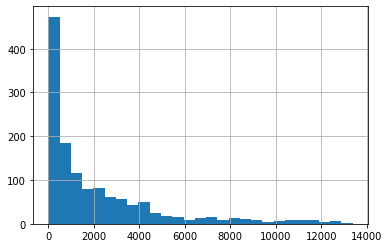

In [8]:
#how many pitches has each pitcher thrown? 
final_play_df.groupby('pitcher_name').count().sort_values('batter_name', ascending=False).iloc[:, 0].hist(bins='fd')

In [9]:
pitchers_top500 = final_play_df.groupby('pitcher_name').count().sort_values('batter_name', ascending=False).iloc[:500, 0].index

In [10]:
df_500 = final_play_df[final_play_df['pitcher_name'].isin(pitchers_top500)]

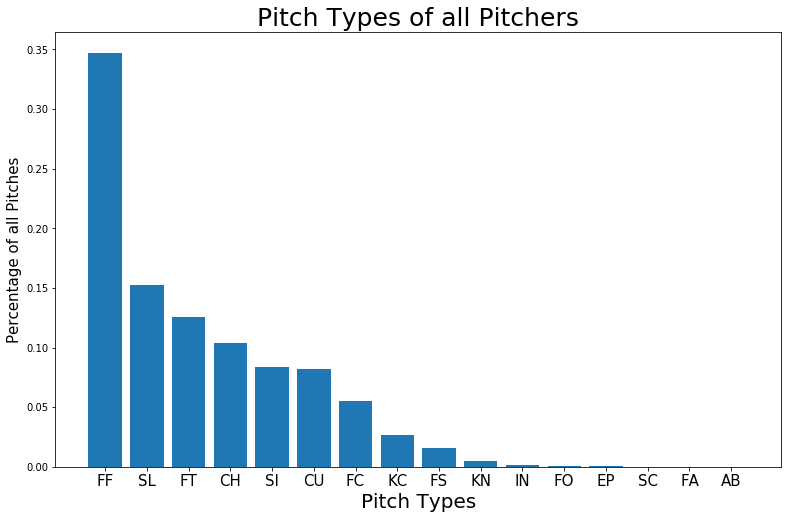

In [17]:
values = df_500.groupby('pitch_type').count().sort_values('pitcher_name', ascending=False).iloc[:, 0].values
index = df_500.groupby('pitch_type').count().sort_values('pitcher_name', ascending=False).iloc[:, 0].index
plt.figure(figsize=(13, 8))
plt.bar(index, values/np.sum(values))
plt.title('Pitch Types of all Pitchers', size=25)
plt.xticks(size=15)
plt.ylabel('Percentage of all Pitches', size=15)
plt.xlabel('Pitch Types', size=20)
plt.savefig('../Graphics/pitch_distribution.png', dpi=100)

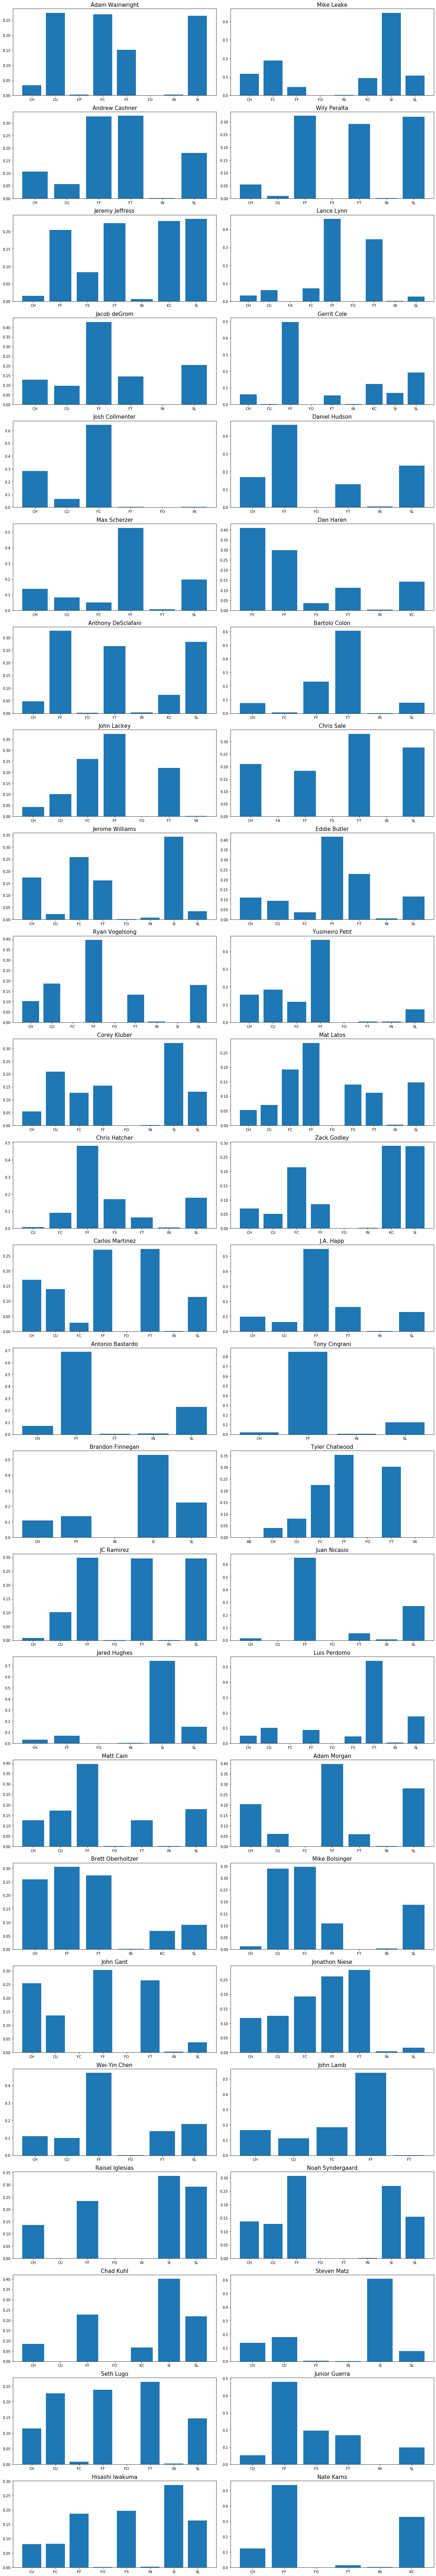

In [18]:
num_pitchers = 50

fig, axs = plt.subplots(num_pitchers // 2, 2, figsize=(17, num_pitchers * 2))

for name, ax in zip(df_500['pitcher_name'].unique()[:num_pitchers], axs.flatten()):
    vals = df_500[df_500['pitcher_name'] == name].groupby('pitch_type').count().sort_values('pitch_type').iloc[:, 0].values
    index = df_500[df_500['pitcher_name'] == name].groupby('pitch_type').count().sort_values('pitch_type').iloc[:, 0].index
    ax.bar(index, vals / np.sum(vals))
    ax.set_title(name, size=15)
plt.tight_layout()

In [26]:
df_500[df_500['pitcher_name'] == 'Hisashi Iwakuma'].groupby('pitch_type').count().sort_values('pitcher_name', ascending=False).iloc[:, 0]

pitch_type
SI    1520
FS    1042
FF     989
SL     864
FC     433
CU     430
IN      12
FO       4
Name: pitcher_name, dtype: int64

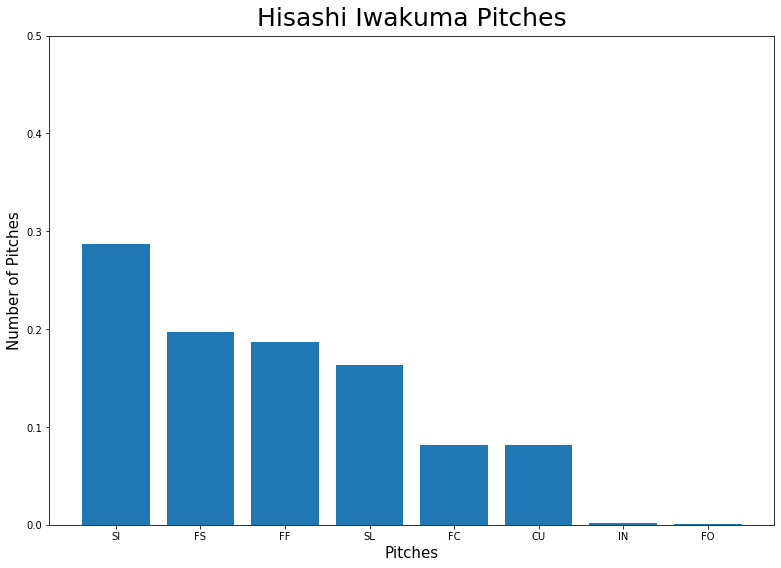

In [30]:
vals = df_500[df_500['pitcher_name'] == 'Hisashi Iwakuma'].groupby('pitch_type').count().sort_values('pitcher_name', ascending=False).iloc[:, 0]
index = df_500[df_500['pitcher_name'] == 'Hisashi Iwakuma'].groupby('pitch_type').count().sort_values('pitcher_name', ascending=False).iloc[:, 0].index
plt.figure(figsize=(13,9))
plt.bar(index, vals / np.sum(vals))

plt.title('Hisashi Iwakuma Pitches', size=25, pad =10)
plt.ylim(0, 0.5)
plt.xlabel('Pitches', size=15)
plt.ylabel('Number of Pitches', size=15)
plt.savefig('../Graphics/hisashi_pitches.png', dpi=100)

In [31]:
def model_each_pitcher(estimator, num_pitchers:int=5, binary:bool=True, randomseed=True):
    if randomseed:
        random.seed(2527)
    
    #lst_pitchers = random.choices(final_play_df['pitcher_name'], k=num_pitchers)
    lst_pitchers = df_500['pitcher_name'].unique()[:num_pitchers]
    cross_val_scores = {}
    test_scores = {}
    for pitcher in lst_pitchers:
        df_pitcher = df_500[df_500['pitcher_name'] == pitcher]
        df = pd.merge(df_pitcher, pd.get_dummies(df_500['batter_name']),left_index=True, right_index=True).drop(columns=['pitcher_name', 'batter_name', 'ab_id', 'batter_id', 'pitcher_id', 'game_id'])
        thresh = round(df.shape[0] * 0.75)
        Xtrain = df.drop(columns='pitch_type').iloc[:thresh, :]
        Xtest = df.drop(columns='pitch_type').iloc[thresh:, :]
        if binary == False:
            ytrain = df['pitch_type'][:thresh].values
            ytest = df['pitch_type'][thresh:].values
        else:
            #this line groups by pitch and sorts it and grabs the most common pitch type to use as a target if predicting with 2 classes
            most_common_pitch = df.groupby('pitch_type').count().sort_values('inning', ascending=False).iloc[:, 0].index[0]   
            ytrain = np.where(df['pitch_type'][:thresh] == most_common_pitch, 1, 0)
        #this is used for cross validation
        #cross_val_scores[pitcher] = [cross_val(estimator, Xtrain.values, ytrain), df.shape[0]]
        
        #this code is used for testing
        model = estimator
        model.fit(Xtrain, ytrain)
        test_scores[pitcher] = model.score(Xtest, ytest)
    return test_scores, #cross_val_scores
    


def cross_val(estimator, X, y):
    '''
    estimator = The model you want to use with the sepcified paramters
                        ex: LogisticRegression(), RandomForestClassification() ...
                        
    data = clean dataframe you are working with, no nans
    
    clean_features = list of features you want to observe in your model
    
    target = target column you want to predict against
    '''

    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    acc_scores = []
    f1_scores = []
    model = estimator   
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        #y_test_pred = model.predict(X_test)
        acc_scores.append(model.score(X_test, y_test))
        
        #change micro to weighted?
        #f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))
        #f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
        #f1_scores.append(f1_score(y_test, y_test_pred, average='micro'))
    
    #if binary:
       # return np.mean(acc_scores)
    #print('F1 Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(f1_scores)))
    #print('Accuracy Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(acc_scores)))
    #print('Recall Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(recall_scores)))
    #print('Precision Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(precision_scores)))
    return np.mean(acc_scores)

In [238]:
#multiclass logistic regression accuracy scores
model_each_pitcher(LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial'), binary=False)

{'Miguel Castro': [0.5507453977886047, 3022],
 'Josh Osich': [0.40664451827242526, 2007],
 'Derek Holland': [0.5023064250411862, 8094],
 'Xavier Cedeno': [0.6126134870083915, 2096],
 'James Shields': [0.35630315205617313, 11784]}

In [237]:
#lets try out of the box random forest classifier to see how it does
#takes way too long
model_each_pitcher(RandomForestClassifier(), binary=False)

{'Miguel Castro': [0.5414767920179712, 3022],
 'Josh Osich': [0.44451827242524916, 2007],
 'Derek Holland': [0.45008237232289944, 8094],
 'Xavier Cedeno': [0.5667637245981194, 2096],
 'James Shields': [0.3587911996455889, 11784]}

In [255]:
#specialized parameters for randomforest classifier 
model_each_pitcher(RandomForestClassifier(n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_depth=6), binary=False)

{'Miguel Castro': [0.4585183456350711, 3022],
 'Josh Osich': [0.3554817275747509, 2007],
 'Derek Holland': [0.5212520593080724, 8094],
 'Xavier Cedeno': [0.4706986149024365, 2096],
 'James Shields': [0.2637490493128164, 11784]}

In [263]:
#tried gradient boosting
model_each_pitcher(GradientBoostingClassifier(), binary=False)

{'Miguel Castro': [0.5578084429792571, 3022],
 'Josh Osich': [0.41262458471760793, 2007],
 'Derek Holland': [0.5080724876441516, 8094],
 'Xavier Cedeno': [0.5903204933778182, 2096],
 'James Shields': [0.39714877070065324, 11784]}

In [21]:
#tried decision tree classifiers which is fastest
model_each_pitcher(DecisionTreeClassifier(), binary = False)

{'Miguel Castro': [0.49733737880600204, 3022],
 'Josh Osich': [0.3893687707641196, 2007],
 'Derek Holland': [0.39769357495881386, 8094],
 'Xavier Cedeno': [0.5388211505408957, 2096],
 'James Shields': [0.32812952136581425, 11784]}

In [112]:
#run decision tree classifier model on first 100 pitchers out of 500, print time
start = time.time()
dict_scores_all = model_each_pitcher(DecisionTreeClassifier(), num_pitchers=500, binary=False)
print(time.time() - start)

2419.850068092346


In [114]:
#pitcher name and accuracy score, and number of pitches
dict_scores_all

{'Adam Wainwright': [0.28718608867291007, 6434],
 'Mike Leake': [0.34931241536332386, 10932],
 'Andrew Cashner': [0.3416478088237783, 10748],
 'Wily Peralta': [0.37916341090538475, 5606],
 'Jeremy Jeffress': [0.3644578783151326, 4270],
 'Lance Lynn': [0.44621327072252664, 9135],
 'Jacob deGrom': [0.3370193647730706, 11699],
 'Gerrit Cole': [0.39555808656036445, 11707],
 'Josh Collmenter': [0.5455799332820119, 2881],
 'Daniel Hudson': [0.41642036124794746, 4060],
 'Max Scherzer': [0.4284005979073243, 13380],
 'Dan Haren': [0.35383317515554147, 2905],
 'Anthony DeSclafani': [0.3331995987963892, 6647],
 'Bartolo Colon': [0.5256401546570466, 10063],
 'John Lackey': [0.37262828197353265, 8698],
 'Chris Sale': [0.38003500758984304, 12582],
 'Jerome Williams': [0.32258082343188726, 2194],
 'Eddie Butler': [0.35051846526181485, 4188],
 'Ryan Vogelsong': [0.32743682310469313, 3697],
 'Yusmeiro Petit': [0.41144475920679885, 4705],
 'Corey Kluber': [0.26758483695698776, 12472],
 'Mat Latos': [0.2

In [115]:
#creates a dataframe from dictionary

keys = []
vals = []
num_pitches = []
for key,value in dict_scores_all.items():   #loops through keys and values
    keys.append(key)
    vals.append(value[0])
    num_pitches.append(value[1])

    
df_all_acc = pd.DataFrame(index=keys)     #creates df and populates using lists from loop
df_all_acc['accuracy'] = vals
df_all_acc['num_pitches'] = num_pitches

In [117]:
df_all_acc.to_csv('../Models/dt_pitcher_accuracy.csv')

In [ ]:
#now lets do the same thing on the testing set to get a score
dic_test = model_each_pitcher(LogisticRegression(solver='lbfgs', multi_class='multinomial'), num_pitchers=500, binary=False)

In [ ]:
keys = []
vals = []

for key,value in dic_test[0].items():   #loops through keys and values
    keys.append(key)
    vals.append(value)

    
df_acc_test = pd.DataFrame(index=keys)     #creates df and populates using lists from loop
df_acc_test['accuracy'] = vals

In [ ]:
#export as a csv to save scores
df_acc_test.to_csv('../Models/accuracy_test.csv')